# Imports

Please note that this page is still being cleaned. I apologize for some of the messiness

In [1]:
import sys
import pprint
import json
import numpy as np
import pandas as pd
from dateutil.parser import parse
from pymongo import MongoClient
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim.summarization.summarizer import summarize
from numpy.linalg import norm
#from scipy.sparse.csc_matrix import transpose

#import seaborn as sns
%matplotlib inline


print("python Version:", sys.version)

python Version: 3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)


# Db Config

In [3]:
client = MongoClient()
db = client.presidents
paragraphs = db.submissions
full_speeches = db.fullspeeches

In [4]:
# speeches.delete_many({})

In [5]:
# with open('/home/karlrudeen/presidentialspeeches9.json', encoding='utf-8') as data_file:    
#     data = json.load(data_file)
#     speeches.insert_many(data)

In [6]:
paragraphs.count()

21968

In [7]:
full_speeches.count()

960

It is worth looking at our speech data on the speech level, and the paragraph within speech model. Speeches tend to cover a wide range of subjects, so when it comes to topic modeling, it may make more sense to model on individual paragraphs within speeches.

In [8]:
par_list = []

for par in paragraphs.find():
    #pprint.pprint(speech)
    if len(par['text']) > 140:
        par['text'] = par['text'].replace('</p>',' ')
        par_list.append(par)
        

#     speech_text.append(speech['text'].replace('<p>', '').\
#                        replace('(Applause.)',' ').replace('(applause)','').replace('inaudible','').split('<br>'))

In [9]:
df_pars = pd.DataFrame(par_list)

In [10]:
fullspeech_list = []

for fullspeech in full_speeches.find():
    if len(fullspeech['text']) > 500:
        fullspeech['text'] = fullspeech['text'].replace('\n',' ')
        fullspeech_list.append(fullspeech)

In [11]:
df_full_speeches = pd.DataFrame(fullspeech_list)

In [12]:
def num_freqs(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return m/len(arr1)   

In [13]:
def num_freqs_tup(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [14]:
def series_to_list(ser):
    return list(ser.tolist())

# NMF

The idea here is to do a grid search on varying levels of maximum document frequency (max_df) and number of topics (n_comps). The lower max_df is, the fewer words are included in the data.

I want to find a combination of n_comps and max_df that gives each president his own signature topic. I need some way to quantify how well the algorithm has done in this regard, so I created a metric. I call the metric Favorite Topic Frequency (FTF). The formula for FTF is FTF = t/s, where t is the total count of speeches by that president that fall under that presidents most frequent topic, and s is the total number of speeches given by that topic.

In [15]:
# #code below commented out because it takes forever to load. Pickles are here instead/

# import pickle

# with open('par_data.pkl', 'wb') as picklefile:
#     pickle.dump(speech_stats, picklefile)

# with open('speech_data.pkl', 'wb') as picklefile:
#     pickle.dump(full_speech_stats, picklefile)

In [16]:
with open("par_data.pkl", 'rb') as picklefile: 
    speech_stats = pickle.load(picklefile)

with open("speech_data.pkl", 'rb') as picklefile: 
    full_speech_stats = pickle.load(picklefile)

In [17]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [5,10,20,30,40]
# speech_stats =[]

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_pars['text'])

#         counts = tfidf_vectorizer.transform(df_pars['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_pars['NMF_topic_num'] = doc_cluster

#         tups = df_pars.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
        
#         speech_stats.append((n_comp, freq, metricthing))

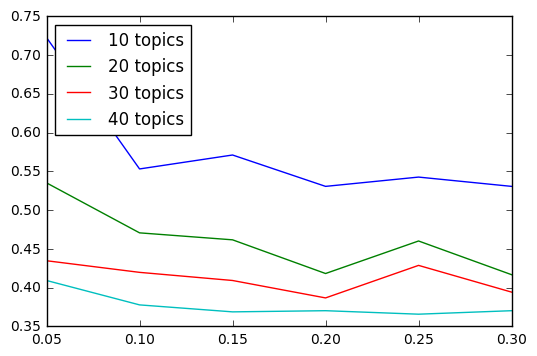

In [18]:
nums_tens = [(num[1],num[2]) for num in speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [19]:
# fullspeech_list = []

# for fullspeech in full_speeches.find():
#     if len(fullspeech['text']) > 500:
#         fullspeech['text'] = fullspeech['text'].replace('\n',' ')
#         fullspeech_list.append(fullspeech)

In [20]:
# df_full_speeches = pd.DataFrame(fullspeech_list)

In [21]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [10,20,30,40]
# full_speech_stats = []

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_full_speeches['text'])

#         counts = tfidf_vectorizer.transform(df_full_speeches['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_full_speeches['NMF_topic_num'] = doc_cluster

#         tups = df_full_speeches.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

#         full_speech_stats.append((n_comp,freq,metricthing))

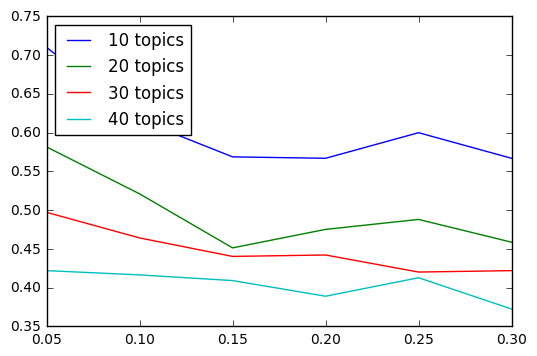

In [22]:
nums_tens = [(num[1],num[2]) for num in full_speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [23]:
def mode(arr):
    arr = [num for num in arr if num !=-1]
    m = max([arr.count(a) for a in arr])
    return [x for x in arr if arr.count(x) == m][0] if m>0 else None

In [24]:
def average_tuples(ser):
    mylist = ser.tolist()
    return [np.mean(tup) for tup in list(zip(*mylist))]

In [25]:
def my_count(arr, thing_to_count):
    return arr.count(thing_to_count)/len([num for num in arr if num !=-1])

In [30]:
n_comp = 20
freq_full = .25

tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1, 2),  
                        stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq_full)
tfidf_vectorizer_full.fit(df_pars['text'])

counts_full = tfidf_vectorizer_full.transform(df_full_speeches['text'])
counts_par = tfidf_vectorizer_full.transform(df_pars['text'])

In [31]:
id2word_full = dict((v, k) for k, v in tfidf_vectorizer_full.vocabulary_.items())

model = NMF(n_components=n_comp, init='random', random_state=0)
model.fit(counts_full)
full_topics = model.transform(counts_full)

par_topics = model.transform(counts_par)

In [32]:
full_cluster = [list(r).index(max(r)) if max(list(r)) > .005 else -1 for r in full_topics]
par_cluster = [list(r).index(max(r)) if max(list(r)) > .002 else -1 for r in par_topics]

In [33]:
full_cluster.count(-1)

5

In [34]:
par_cluster.count(-1)/len(par_cluster)

0.0184569451041596

In [35]:
df_full_speeches['NMF_topic_num'] = full_cluster
df_full_speeches['NMF_topic_amts'] = [tuple(doc) for doc in full_topics]

In [36]:
df_pars['NMF_topic_num'] = par_cluster

In [37]:
df_pars['NMF_topic_amts'] = [tuple(doc) for doc in par_topics]


# okeything = df_full_speeches.groupby('president').agg({
#     'NMF_topic_num': num_freqs_tup,
#     'NMF_topic_amts' : average_tuples
#     })['NMF_topic_num']

tups = df_pars.groupby('president').agg({
    'NMF_topic_num': num_freqs_tup
    })['NMF_topic_num']
metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

okeydoke = df_full_speeches.groupby('president', as_index = False).agg({
    'NMF_topic_num': series_to_list,
    'NMF_topic_amts' : average_tuples
    })

In [ ]:
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([id2word_full[e[1]] for e in a])

In [ ]:
df_pars['date_obj'] = df_pars['date'].apply(parse)

In [ ]:
for i in range(n_comp):
    okeydoke['topic_' + str(i)] = okeydoke['NMF_topic_num'].apply(lambda x: my_count(x,i))
    #okeydoke['topic_amt_' + str(i)] = okeydoke['NMF_topic_amts'].apply(lambda x: x[i]/sum(x))

In [ ]:
okeydoke['kmeans'] = KMeans(n_clusters = 7).fit_predict(okeydoke.iloc[:,3:23].as_matrix())

In [ ]:
okeydoke['kmeans'].value_counts()

In [ ]:
okeydoke[okeydoke['kmeans']==4]['president']

In [ ]:
most_freq_topics[15]

This is the crux of the whole project. A function that takes in a president, outputs that presidents signature topic, a paragraph of text summarizing his speeches on that topic, and some similar presidents ( based on distance and clustering)

In [ ]:
given_president = 'George W. Bush'
pres_row = okeydoke[okeydoke['president'] == given_president].iloc[0]
kmeans_cluster_num = int(pres_row['kmeans'])

closest_presidents = okeydoke[(okeydoke['kmeans'] == kmeans_cluster_num) & (okeydoke['president'] != given_president)]
if closest_presidents.shape[0] > 5:
    closest_presidents['distancesfromgiven'] = closest_presidents.apply(lambda row :norm(np.array(list(row)[3:23]) - np.array(list(pres_row)[3:23])), axis = 1)
    closest_presidents = closest_presidents.sort_values(by = 'distancesfromgiven', ascending = True).iloc[1:4,:]

most_freq_topics = list(pres_row['NMF_topic_num'])
most_freq_topic = mode(most_freq_topics)
print(topic_words[most_freq_topic])
print(list(closest_presidents['president']))
big_text_thing = ' '.join(list(df_pars[(df_pars['NMF_topic_num'] == most_freq_topic) & (df_pars['president'] == given_president)]['text'])) #& (df_speeches['president'] == 'Barack Obama')]['text']))

In [ ]:
summarize(big_text_thing, split = True)[:3]

In [ ]:
most_freq_topics = list(pres_row['NMF_topic_num'])


In [ ]:
topic_words[2]

In [ ]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

In [ ]:
LANGUAGE = "english"
SENTENCES_COUNT = 10
parser = PlaintextParser.from_string(big_text_thing, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

In [ ]:
Summar = Summarizer(big_text_thing)

In [ ]:
thing= summarize(big_text_thing, split = True)

In [ ]:
thing[1]

In [ ]:
topic_words[1]

In [ ]:
okeydoke[okeydoke['kmeans'] == 0]

# metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

In [ ]:
df_full_speeches[df_full_speeches['NMF_topic_num'] == 2]

In [ ]:
okeydoke

In [ ]:
okeydoke[okeydoke['KMeans'] == 2]

In [ ]:
np.bincount(sum(most_freq_topics,[]))

In [ ]:
mode(sum(most_freq_topics,[]))

In [ ]:
same_cluster_presidents
X = np.array(same_cluster_presidents.ix[4,2:22])
list(pres_row)

In [ ]:
pres_row = okeydoke[okeydoke['president'] == given_president]


In [ ]:
list(pres_row.iloc[0])

In [ ]:
same_cluster_presidents.ix[:,2:22]

In [ ]:
find_three_closest(same_cluster_presidents)

In [ ]:
norm([1,1])

In [ ]:

nums = [(10, 0.05, 0.723404255319149),
 (20, 0.05, 0.598404255319149),
 (30, 0.05, 0.5159574468085106),
 (40, 0.05, 0.4521276595744681),
 (10, 0.1, 0.6542553191489362),
 (20, 0.1, 0.5851063829787234),
 (30, 0.1, 0.5132978723404256),
 (40, 0.1, 0.4601063829787234),
 (10, 0.15, 0.6675531914893617),
 (20, 0.15, 0.5053191489361702),
 (30, 0.15, 0.47074468085106386),
 (40, 0.15, 0.42819148936170215),
 (10, 0.2, 0.6117021276595744),
 (20, 0.2, 0.5531914893617021),
 (30, 0.2, 0.4627659574468085),
 (40, 0.2, 0.40425531914893614),
 (10, 0.25, 0.6223404255319149),
 (20, 0.25, 0.5425531914893617),
 (30, 0.25, 0.48404255319148937),
 (40, 0.25, 0.4228723404255319),
 (10, 0.3, 0.6595744680851063),
 (20, 0.3, 0.5159574468085106),
 (30, 0.3, 0.4601063829787234),
 (40, 0.3, 0.39361702127659576)]

In [ ]:
nums_tens = [(num[1],num[2]) for num in nums if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in nums if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in nums if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in nums if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')
